<a href="https://colab.research.google.com/github/AlexandreBourrieau/ML/blob/main/Carnets%20Jupyter/Series_caracteristiques.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Découvrons quelques séries temporelles afin de mieux comprendre les caractéristiques de ce type de données.

# Importation des bibliothèques

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

Fonction permettant d'afficher une série temporelle



In [4]:
def affiche_serie(temps, serie, format="-", debut=0, fin=None, label=None):
    plt.plot(temps[debut:fin], serie[debut:fin], format, label=label)
    plt.xlabel("Temps")
    plt.ylabel("Valeur")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

# Tendance et saisonnalité

Définition d'une fonction pour créer un courbe de tendance avec une pente que l'on peut choisir

In [5]:
def tendance(temps, pente=0):
    return pente * temps

Création d'une série temporelle avec la fonction précédente :

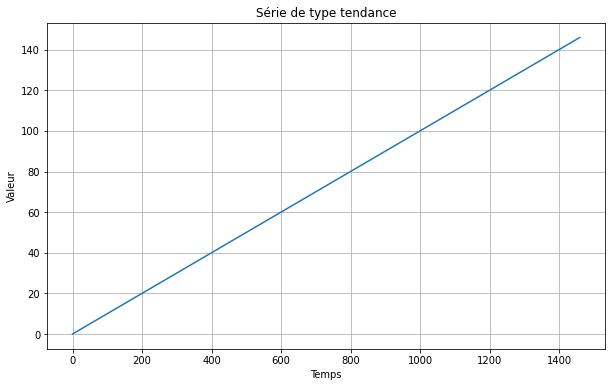

In [6]:
temps = np.arange(4 * 365 + 1)            # temps = [0 1 2 .... 4*365] = [0 1 2 .... 1460]
serie = tendance(temps, 0.1)              # serie = droite de pente 0.1

plt.figure(figsize=(10, 6))
affiche_serie(temps, serie)
plt.title("Série de type tendance")
plt.show()

Ajoutons maintenant un motif périodique à notre série. Tout d'abord, définissons le motif que nous allons répéter :

$motif = \left\{ {\begin{array}{*{20}{c}}
{\cos \left( {2\pi t} \right){\rm{       }}\qquad0 \le t < 0.4}\\
{{e^{ - 3t}}{\rm{                }}\qquad\qquad0.4 \le t \le 1}
\end{array}} \right.$

Text(0.5, 1.0, 'Motif')

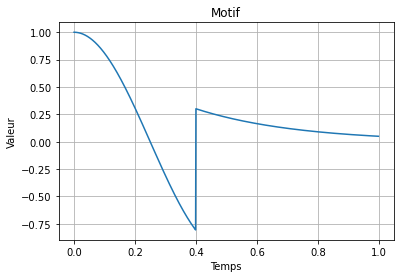

In [7]:
# Définition du motif périodique sur t:[0:1]
t = np.arange(1000)
t = t/1000
motif = np.where(t < 0.4,np.cos(t * 2 * np.pi),1 / np.exp(3 * t))

# Affichage du motif sur t:[0,1]
plt.plot(t[0:1000], motif[0:1000], "-", label="Motif")
plt.xlabel("Temps")
plt.ylabel("Valeur")
plt.grid(True)
plt.title("Motif")

Définissons maintenant les fonctions pour ajouter le motif à notre courbe de tendance :  
- `motif_periodique`: Cette fonction créée le motif sur des instants t = [0,1]
- `ajoute_motif` : Cette fonction ajoute le motif à la série 

In [8]:
def motif_periodique(instants):
    return (np.where(instants < 0.4,                            # Si les instants sont < 0.4
                    np.cos(instants * 2 * np.pi),               # Alors on retourne la fonction cos(2*pi*t)
                    1 / np.exp(3 * instants)))                  # Sinon, on retourne la fonction exp(-3t)

def saisonnalite(temps, periode, amplitude=1, phase=0):
    """Répétition du motif sur la même période"""
    instants = ((temps + phase) % periode) / periode            # Mapping du temps =[0 1 2 ... 1460] => instants = [0.0 ... 1.0]
    return amplitude * motif_periodique(instants)

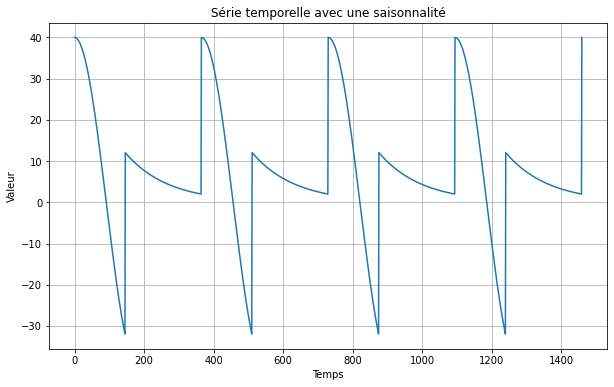

In [9]:
# Création de la série avec une saisonnalité
amplitude = 40
serie = saisonnalite(temps, periode=365, amplitude=amplitude)

#Affichage du résultat
plt.figure(figsize=(10, 6))
affiche_serie(temps, serie)
plt.title("Série temporelle avec une saisonnalité")
plt.show()


Ajoutons maintenant une tendance à cette série :

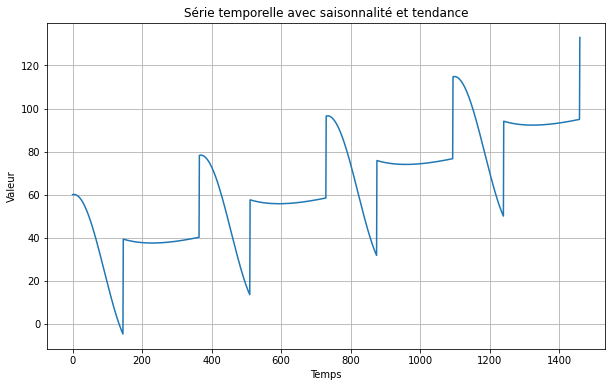

In [10]:
# Création d'une tendance et ajout de la tendance à la série
offset = 20
pente = 0.05
serie = offset + tendance(temps, pente) + saisonnalite(temps, periode=365, amplitude=amplitude)

# Affichage du résultat
plt.figure(figsize=(10, 6))
affiche_serie(temps, serie)
plt.title("Série temporelle avec saisonnalité et tendance")
plt.show()

# Bruit

En pratique, très peu de séries temporelles sont aussi jolies ! Elles ont souvent du bruit, et le ratio signal / bruit peut parfois être très faible.  
Générons du [bruit blanc](https://fr.wikipedia.org/wiki/Bruit_blanc) :

In [11]:
# Fonction permettant de générer du bruit gaussien N(0,1)
def bruit_blanc(temps, niveau_bruit=1, graine=None):
    rnd = np.random.RandomState(graine)
    return rnd.randn(len(temps)) * niveau_bruit

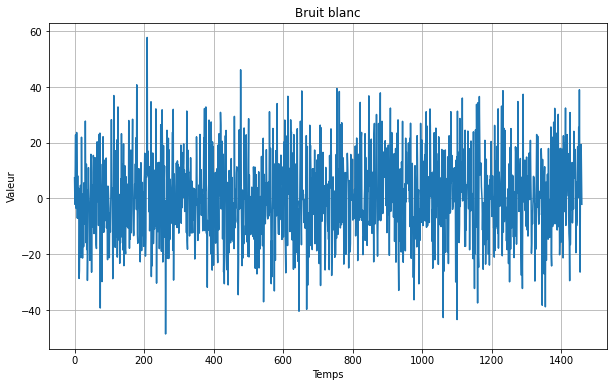

In [12]:
# Création du bruit
niveau_bruit = 15
bruit = bruit_blanc(temps, niveau_bruit, graine=42)

# Affichage du résultat
plt.figure(figsize=(10, 6))
affiche_serie(temps, bruit)
plt.title("Bruit blanc")
plt.show()

Ajoutons maintenant ce bruit à notre série temporelle :

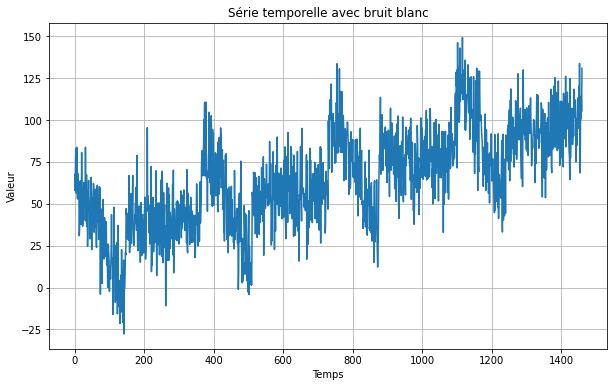

In [13]:
# Ajoute le bruit gaussien à la série temporelle
serie = serie + bruit

# Affiche le résultat
plt.figure(figsize=(10, 6))
affiche_serie(temps, serie)
plt.title("Série temporelle avec bruit blanc")
plt.show()

# Séries autocorrélées

Définissons maintenant deux séries autocorrélées basées sur des bruits blancs :  

$\left\{ \begin{array}{l}
{v_1}(t) = v_1(t) + 0.8v_1(t - 1)\\
{v_2}(t) = v_2(t) + 0.5v_2(t - 50) - 0.1v_2(t - 33)
\end{array} \right.$  
  
  Avec : $v_1(t)$ et $v_2(t)$ bruit blanc

In [14]:
# Série autocorrélée #1
# v1(t) = v1(t) + 0.8v1(t-1) , avec v1(t) = bruit blanc

def autocorrelation1(temps, amplitude, graine=None):
    rnd = np.random.RandomState(graine)                 # Initialisation de la graine
    v1 = rnd.randn(len(temps) + 1)                      # Génération du bruit blanc sur t:[0:temps+1]
    k1 = 0.8
    for step in range(1, len(temps) + 1):               # Pour chaque pas de temps :
      v1[step] = v1[step] + k1 * v1[step - 1]           # v1(t) = v1(t) + k1*v1(t-1)
    return v1[1:] * amplitude                           # Retourne amplitude*v1(t) sur t:[1:temps+1]

In [15]:
# Série autocorrélée #2
# v2(t) = v2(t) + 0.5v2(t-50) - 0.1v2(t-30), avec v2(t) = bruit blanc

def autocorrelation2(temps, amplitude, graine=None):
    rnd = np.random.RandomState(graine)                 # Initialisation de la graine
    v2 = rnd.randn(len(temps) + 50)                     # Génération du bruit blanc sur t:[0:temps+50]
    v2[:50] = 100                                       # Si t<50 : v2(t)=100
    k1 = 0.5
    k2 = -0.1
    for step in range(50, len(temps) + 50):             # Pour chaque pas de temps:
        v2[step] = v2[step] + k1 * v2[step - 50]        # v2(t) = v2(t) + 0.5v2(t-50) - 0.1v2(t-33) 
        v2[step] = v2[step] + k2 * v2[step - 33]
    return v2[50:] * amplitude                          # Retourne amplitude*v2(t) sur t:[50:temps+50]

Affichons la série autocorrélée n°1 : ${v_1}(t) = v_1(t) + 0.8v_1(t - 1)$ sur l'intervalle $t\in[0;200]$

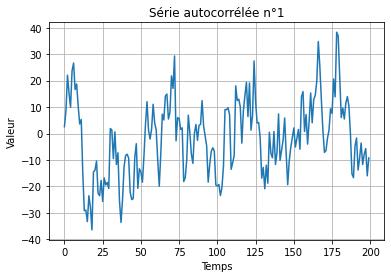

In [16]:
# Affiche v1(t) sur t:[0:200]

serie = autocorrelation1(temps, 10, graine=42)
affiche_serie(temps[:200], serie[:200])
plt.title("Série autocorrélée n°1")
plt.show()

Affichons la série autocorrélée n°2 : ${v_2}(t) = v_2(t) + 0.5v_2(t - 50) - 0.1v_2(t-30)$ sur l'intervalle $t\in[0;200]$

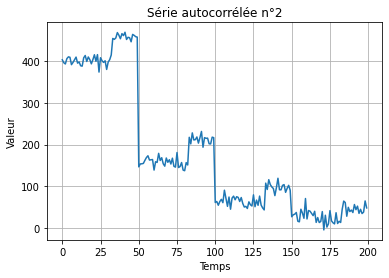

In [17]:
# Affiche v2(t) sur t:[0:200]

serie = autocorrelation2(temps, 10, graine=42)
affiche_serie(temps[:200], serie[:200])
plt.title("Série autocorrélée n°2")
plt.show()

# Série autocorrélée avec tendance et saisonnalité

Ajoutons une tendance à la série autocorrélée n°2 :

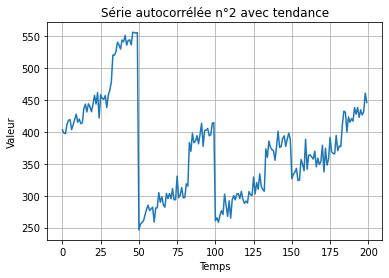

In [18]:
serie = autocorrelation2(temps, 10, graine=42) + tendance(temps, 2)
affiche_serie(temps[:200], serie[:200])
plt.title("Série autocorrélée n°2 avec tendance")
plt.show()

Ajoutons une tendance et une saisonnalité sur la série autocorrélée n°1 :

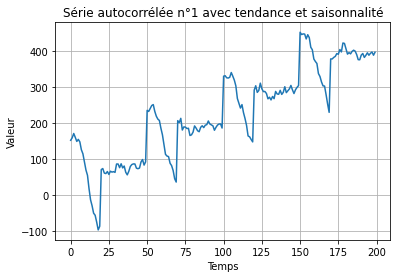

In [19]:
serie = autocorrelation1(temps, 10, graine=42) + saisonnalite(temps, periode=50, amplitude=150) + tendance(temps, 2)
affiche_serie(temps[:200], serie[:200])
plt.title("Série autocorrélée n°1 avec tendance et saisonnalité")
plt.show()

# Série autocorrélé avec une "cassure"

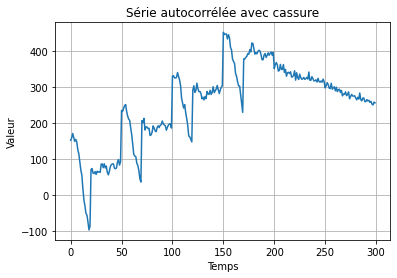

In [20]:
# Concaténation des deux séries
serie1 = autocorrelation1(temps, 10, graine=42) + saisonnalite(temps, periode=50, amplitude=150) + tendance(temps, 2)
serie2 = autocorrelation2(temps, 5, graine=42) + saisonnalite(temps, periode=50, amplitude=2) + tendance(temps, -1) + 550

serie1[200:] = serie2[200:]                       # serie1 sur t:[0:200] puis serie2 si t:[200,tmax]
#serie1 = serie1 + bruit_blanc(temps, 30)         # Ajout de bruit blanc à la série finale
affiche_serie(temps[:300], serie1[:300])
plt.title("Série autocorrélée avec cassure")
plt.show()

# Séries impulsionnelle

Commençons par construire une série impulsionnelle $v_i(t)$ avec des trains d'impulsions à des instants aléatoires et avec des amplitudes aléatoires :

In [21]:
# Fonction pour construire des impulsions

def impulsions(temps, nbr_impulsions, amplitude=1, graine=None):
    rnd = np.random.RandomState(graine)                       # Initialisaiton de la graine
    indices_impulsions = rnd.randint(len(temps), size=10)     # Tire au hasard 10 instants
    serie = np.zeros(len(temps))                              # Initialise la série avec des 0
    for index in indices_impulsions:
        serie[index] = serie[index] + rnd.rand() * amplitude  # Ajoute les impulsions aux instants aléatoires
    return serie    

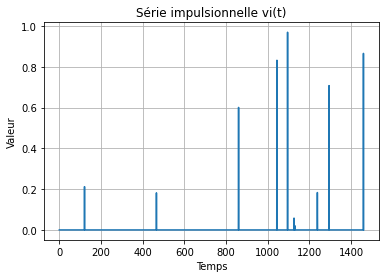

In [22]:
# Affiche la série d'impulsions
serie = impulsions(temps, 10, graine=42)
affiche_serie(temps, serie)
plt.title("Série impulsionnelle vi(t)")
plt.show()

# Série impulsionnelle autocorrélée

Définissons une fonction qui permet d'introduire une autocorrélation que nous appliquerons sur la série impulsionnelle.  

Pour un signal $s(t)$, la fonction construit : $s(t) = s(t) + K_1s(t-t_1) + K_2s(t-t_2) + K_3s(t-t_3) + ...$  

Les coefficients $K_1$, $K_2$, $K_3$... et les délais $t_1$, $t_2$, $t_3$, ... sont transmis en paramètre dans un dictionnaire : {"$t_1$:$K_1$","$t_2$:$K_2$",$t_3$:$K_3$",...) 


In [23]:
# Fonction permettant d'introduire une autocorrélation sur un signal
# La fonction retourne : v(t) = v(t)+ K*v(t-delai)
# Les délais et les valeurs des amplitudes des décalages sont donnés
# dans un dictionnaire : decalages = {"delai1:K1", "delai2:K2", ...}

def autocorrelation(source, decalages):
    ar = source.copy()
    n_max = len(decalages)                        # Nombre de décalages max donné en paramètre
    for step, valeur in enumerate(source):        # Pour chaque instant et chaque valeur du signal
        for delai, K in decalages.items():        # Pour chaque instant et chaque amplitude de décalage
            if step - delai > 0:
              ar[step] = ar[step] + K * ar[step - delai]
    return ar

Construisons maintenant la série impulsionnelle autocorrélée :

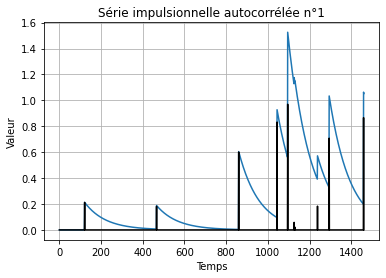

In [28]:
# Création de la série impulsionnelle autocorrélée
# v(t) = v(t) + 0.99v(t-1) 

signal = impulsions(temps, 10, graine=42)       # signal = série impulsionnelle
serie = autocorrelation(signal, {1: 0.99})      # Applique l'autocorrélation au signal
                                                # v(t) = v(t) + 0.99v(t-1)
affiche_serie(temps, serie)
plt.plot(temps, signal, "k-")
plt.title("Série impulsionnelle autocorrélée n°1")
plt.show()

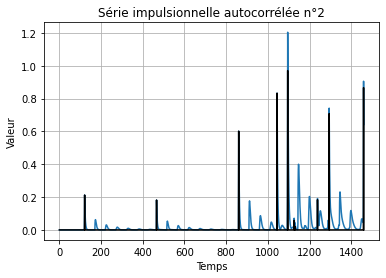

In [29]:
# Création de la série impulsionnelle autocorrélée
# v(t) = v(t) +  0.7v(t-1) + 0.2v(t-50)

signal = impulsions(temps, 10, graine=42)
serie = autocorrelation(signal, {1: 0.70, 50: 0.2})
affiche_serie(temps, serie)
plt.plot(temps, signal, "k-")
plt.title("Série impulsionnelle autocorrélée n°2")
plt.show()